In [1]:
! curl https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip > PennFudanPed.zip \
&& unzip -q PennFudanPed.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.2M  100 51.2M    0     0  26.5M      0  0:00:01  0:00:01 --:--:-- 26.5M


In [2]:
import os
import time

import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset
from sklearn.metrics import auc
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)           # note that we haven't converted the mask to RGB, because each color corresponds to a different instance with 0 being background
        mask = np.array(mask)

        obj_ids = np.unique(mask)              # instances are encoded as different colors
        obj_ids = obj_ids[1:]                  # first id is the background, so remove it
        masks = mask == obj_ids[:, None, None] # split the color-encoded mask into a set of binary masks

        num_objs = len(obj_ids)                # get bounding box coordinates for each mask
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) # convert everything into a torch.Tensor
        labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        image_id = torch.tensor([idx])

        target = {"boxes": boxes, "labels": labels, "image_id": image_id}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def get_transform(train=False):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
dataset = PennFudanDataset("PennFudanPed/", get_transform())

In [6]:
from PIL.ImageDraw import Draw

image, labels = next(iter(dataset))

image = T.ToPILImage()(image)
draw = Draw(image)

for box in labels["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

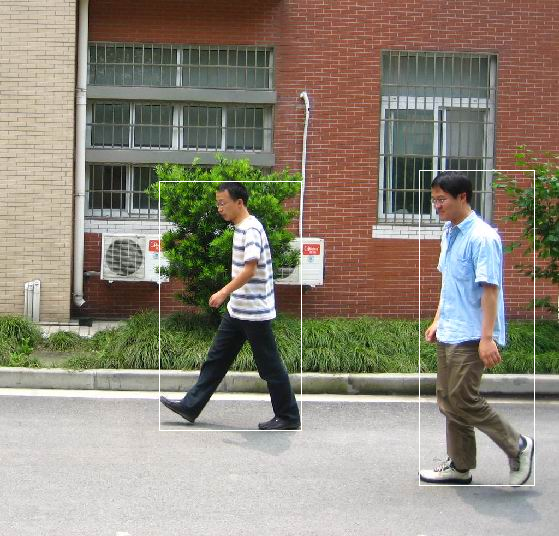

In [7]:
image

In [8]:
num_classes = 2

In [9]:
def get_detection_model(num_classes):

    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features      # get the number of input features for the classifier

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)    # replace the pre-trained head with a new one

    return model

In [10]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    intersection_box = np.array([max(dt_bbox[0], gt_bbox[0]),  # x_min 2
                                 max(dt_bbox[1], gt_bbox[1]),  # y_min 1
                                 min(dt_bbox[2], gt_bbox[2]),  # x_max 2
                                 min(dt_bbox[3], gt_bbox[3])]) # y_max 1

    intersection_area = max(intersection_box[2]-intersection_box[0], 0)*max(intersection_box[3]-intersection_box[1], 0)

    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    iou = intersection_area / (dt_area + gt_area - intersection_area)

    return iou

In [11]:
dt_bbox = [0, 0, 2, 2]
gt_bbox = [1, 1, 3, 3]
intersection_over_union(dt_bbox, gt_bbox)

0.14285714285714285

In [12]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    # предсказания модели
    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5
            detection_result_dict["TP"] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results

In [13]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [14]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss

def train(model, num_epochs, train_loader, test_loader, optimizer, device):
    for epoch in range(1, num_epochs+1):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = PennFudanDataset("PennFudanPed", get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])
data_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=2, shuffle=True,
                                          num_workers=4, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                               batch_size=1, shuffle=False,
                                               num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train(model, num_epochs, data_loader, data_loader_test, optimizer, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 82.9MB/s]


epoch 1/5..
Loss value after 10 batches is 0.53
Loss value after 20 batches is 0.39
Loss value after 30 batches is 0.33
Loss value after 40 batches is 0.3
Loss value after 50 batches is 0.28
Loss value after 60 batches is 0.25
epoch 1 done in 42.77s
mAP after epoch 1 is 0.985:
epoch 2/5..


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss value after 10 batches is 0.13
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.13
Loss value after 40 batches is 0.13
Loss value after 50 batches is 0.13
Loss value after 60 batches is 0.12
epoch 2 done in 36.2s
mAP after epoch 2 is 0.988:
epoch 3/5..


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss value after 10 batches is 0.07
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.08
Loss value after 40 batches is 0.08
Loss value after 50 batches is 0.08
Loss value after 60 batches is 0.09
epoch 3 done in 36.65s
mAP after epoch 3 is 0.986:
epoch 4/5..


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss value after 10 batches is 0.08
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.08
Loss value after 40 batches is 0.08
Loss value after 50 batches is 0.08
Loss value after 60 batches is 0.08
epoch 4 done in 36.97s
mAP after epoch 4 is 0.986:
epoch 5/5..


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss value after 10 batches is 0.06
Loss value after 20 batches is 0.06
Loss value after 30 batches is 0.06
Loss value after 40 batches is 0.06
Loss value after 50 batches is 0.06
Loss value after 60 batches is 0.06
epoch 5 done in 38.16s
mAP after epoch 5 is 0.987:


_______________________________________________________

In [18]:
image, labels = next(iter(dataset_test))
pred = model(image.unsqueeze(0).to(device))[0]

In [19]:
image = T.ToPILImage()(image)
draw = Draw(image)
for box in labels["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

for box in pred["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red")

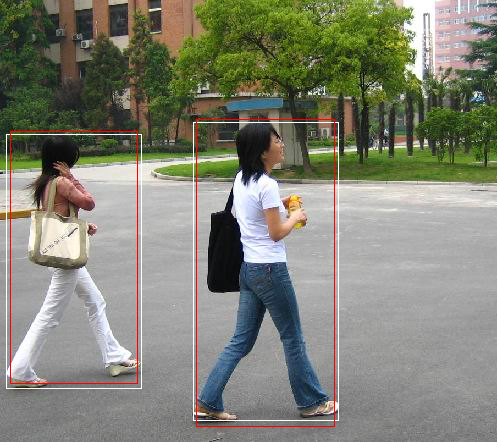

In [20]:
image

In [21]:
pred

{'boxes': tensor([[196.7911, 119.3801, 334.8912, 426.0661],
         [ 10.0737, 131.3806, 137.7247, 383.2884]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9987, 0.9981], device='cuda:0', grad_fn=<IndexBackward0>)}

In [ ]:
intersection_over_union(pred["boxes"][0], pred["boxes"][1])